## Introduction

## Loading Packages

In [291]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.preprocessing import Imputer    # 옛날 코드
from sklearn.impute import SimpleImputer   # Null Value 처리

from sklearn.preprocessing import PolynomialFeatures   # Numeric 피쳐를 곱해서 Feature Engineering을 편하게 하기위해
from sklearn.preprocessing import StandardScaler

# Selection: 너무많은 Feature를 생성 시에 다중 공선성 등 문제가 발생 -> 중요한 Feature를 선택
from sklearn.feature_selection import VarianceThreshold   # 변수의 Variance가 작다는 것은 정보를 적게 가지고 있다는 것, 이를 가지고 selection
from sklearn.feature_selection import SelectFromModel   # 모델마다 변수에 중요도를 매김, 이를 가지고 selection
# Selection 시 하나의 모델로만 변수를 선택하게 되면 모델별로 중요한 변수가 치우칠 수 있음, 여러 알고리즘을 가지고 해보는게 좋다. (트리, Linear, SVM 등)
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## Loading Data

In [292]:
# 디버깅 시 팁   /  Data가 너무 많은 경우 디버깅을 빠르게 할 수 없으므로 데이터 수를 줄여서 사용

DEBUG = False   # True는 디버그 모드, False는 전체 데이터 사용

if DEBUG:
    NROWS = 500000
else:
    NROWS = None

- EDA할 때 데이터가 너무 많으면 5만개~10만개, 100만개 정도로만 하자. PC사양에 따라 적절하게

In [293]:
train = pd.read_csv('../input/porto-seguro-safe-driver-prediction/train.csv', nrows=NROWS)
test = pd.read_csv('../input/porto-seguro-safe-driver-prediction/test.csv', nrows=NROWS)

# train = train.sample(frac=0.1)    # 위의 디버깅 방법외에도 이 코드로 비율을 뽑아서 쓸 수 있음

In [294]:
# 클래스의 불균형이 걱정되면 아래의 코드 StratifiedKFold 사용해서 샘플링

# from sklearn.model_selection import StratifiedKFold
# fold = StratifiedKFold(n_splits=10, random_state=38)
# for train_idx, val_idx in fold.split(train, train['target']):
#     break
# train = train.iloc[train_idx]

## Data at First sight & Column description
- 컬럼명 뒤쪽에 붙어있는 것
    - bin = 바이너리
    - cat = 카테고리
    - 없는것은 = continuous or ordinal
    - Missing Value = -1
    - Target = 0, 1

In [295]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [296]:
# 변수 중 카테고리컬 피처만을 뽑기

cat_cols= [col for col in train.columns if 'cat' in col]    # cat이라는 단어가 포함되어있는 컬럼
cat_cols

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [297]:
# 카테고리컬 피처의 분포보기 (정수형인지, 몇개의 Unique한 클래스를 가지는지)
# Categorical의 13번째 피처는 104개의 클래스 = high cardinality(고차원),  따라서 원핫대신 다른 Encoding 방법 사용

for col in cat_cols:
    print(col, train[col].nunique(), train[col].unique())

ps_ind_02_cat 5 [ 2  1  4  3 -1]
ps_ind_04_cat 3 [ 1  0 -1]
ps_ind_05_cat 8 [ 0  1  4  3  6  5 -1  2]
ps_car_01_cat 13 [10 11  7  6  9  5  4  8  3  0  2  1 -1]
ps_car_02_cat 3 [ 1  0 -1]
ps_car_03_cat 3 [-1  0  1]
ps_car_04_cat 10 [0 1 8 9 2 6 3 7 4 5]
ps_car_05_cat 3 [ 1 -1  0]
ps_car_06_cat 18 [ 4 11 14 13  6 15  3  0  1 10 12  9 17  7  8  5  2 16]
ps_car_07_cat 3 [ 1 -1  0]
ps_car_08_cat 2 [0 1]
ps_car_09_cat 6 [ 0  2  3  1 -1  4]
ps_car_10_cat 3 [1 0 2]
ps_car_11_cat 104 [ 12  19  60 104  82  99  30  68  20  36 101 103  41  59  43  64  29  95
  24   5  28  87  66  10  26  54  32  38  83  89  49  93   1  22  85  78
  31  34   7   8   3  46  27  25  61  16  69  40  76  39  88  42  75  91
  23   2  71  90  80  44  92  72  96  86  62  33  67  73  77  18  21  74
  37  48  70  13  15 102  53  65 100  51  79  52  63  94   6  57  35  98
  56  97  55  84  50   4  58   9  17  11  45  14  81  47]


In [298]:
# Train 데이터의 중복여부 확인,  중복이 존재하지 않음

train.drop_duplicates()
train.shape

(595212, 59)

In [299]:
# 변수의 정보확인, 모두 int 및 Float /  Object형 즉, String형태의 컬럼은 없음
# Null Data도 확인 / 여기는 -1로 다 치환되어 있기 때문에 없음

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

## Metadata
- 데이터 변수들에 대한 여러 정보를 데이터프레임 형태로 저장해놓기
- 이는 이후 분석, 시각화, 모델링을 수행할 때 변수를 선택할 때 충분히 도움이 된다.
    
#### 저장할 정보들
    - role: input, ID, target
    - level: nominal, interval, ordinal, binary
    - keep: True or False
    - dtype: int, float, str

In [300]:
data = []

for column in train.columns:     # Column을 하나씩 가져오기

    # role 정의하기 (Input(X변수), Target(Y변수), ID)
    
    if column =='target':     # 컬럼명이 target 값 인지
        role = 'target'
    elif column == 'id':      # 컬럼명이 id인지
        role = 'id'
    else:
        role = 'input'        # 컬럼명이 나머지 Input으로 사용할 변수인지를 role에 저장

    # level 정의하기 (변수의 Type)

    if 'bin' in column or column =='target':
        level = 'binary'      # 이진형  
    elif 'cat' in column or column =='id':
        level = 'nominal'     # 명목형
    elif train[column].dtype == 'float64':
        level = 'interval'    # 구간형,  Ex) 온도
    elif train[column].dtype == 'int64':
        level = 'ordinal'     # 순서형,  0 < 1 < 2 < 3 < 4와 같이 순서의 의미를 지님

    keep = True            # 추후에 Feature를 많이 만들었을 때 사용하지 않는 변수들은 False로 만들어 놓으면서 사용
    if column == 'id':
        keep = False

    dtype = train[column].dtype    # 데이터의 타입

    column_dict = {'variable_name': column, 'role': role, 'level': level, 'keep': keep, 'dtype': dtype}   # 딕셔너리 형태로 여러 정보를 저장

    data.append(column_dict)     # 각 컬럼마다 리스트에 추가

In [301]:
meta = pd.DataFrame(data)     # 데이터 프레임 형태로 meta라는 변수에 저장

In [302]:
meta.set_index('variable_name', inplace=True)    # 변수이름을 인덱스로 지정, inplace는 meta변수에 바로 적용하겠다

In [303]:
meta

,role,level,keep,dtype
variable_name,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


- 이렇게 뽑아놓은 이유: 변수를 Drop하지 않으면서 원하는 컬럼들을 뽑아올 수 있기 때문에

In [304]:
# nominal 이면서 id가 아닌(keep=True) 변수명 뽑아오기

meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='variable_name')

- 변수의 role, level 기준으로 몇개씩 존재하는지 요약

In [305]:
# role, level 기준으로 

pd.DataFrame({"count": meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


- 각 변수들의 통계량을 요약해두면 좋음
- 그런데 Categorical은 빈도수를 제외하면 별로 의미가 없기 때문에 따로 뽑아서 사용

In [306]:
# 카테고리컬 피처 저장

categorical_features = [col for col in train.columns if 'cat' in col]

## Descriptive statistics

- 각 변수의 평균, 분산 등의 통계량을 계산해서 볼 필요가 있다. 
- 그런데, 카테고리컬 변수 같은 경우에는 평균, 분산과 같은 것이 의미가 없기 때문에 각 변수 타입별로 나누어서 볼 필요가 있다.

### Interval 변수 (구간형,  e.g. 온도)

In [307]:
# 변수의 타입이 interval 이면서 id를 제외한 나머지 변수들의 index(변수명))을 v에 저장

v = meta[(meta.level == 'interval') & (meta.keep)].index

In [308]:
# interval, 즉 continuous한 변수들의 통계량

train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


- reg 변수 중 ps_reg_03 변수만 missing value가 존재, min 값이 -1로 되어있음

- 변수의 값 (min to max)들이 변수간에 많이 차이날 경우에는 Scailing(Standard Scaler)을 해줄 필요가 있다. (classifier에 따라서 필요하지 않은 경우도 있음, ex.Tree Model)

- ps_calc_01, 02, 03 변수들은 분포가 거의 비슷하다 (max=0.9, min, mean, var 거의 비슷)

### Ordinal 변수 (순서형)

In [309]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


- ps_car_11만 missing value 존재

- 변수들 값의 range가 좀 차이나므로 scaling 필요

### Binary 변수

In [310]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- Target값을 보면 0,1로 이루어져 있는데 mean값이 0.0364 / 매우 불균형한 데이터
- 대부분 보험 청구가 되지 않았다.

- no missing value

## 클래스의 불균형을 다루기 (Handling imbalanced classes)

- Target=0 인 것이 약 96.4% 정도를 차지하고 있음

- 이를 Accuracy 관점에서 0으로만 예측해도 정확도가 96.4%로 좋은 모델이 나옴

- 하지만, 실제로는 1을 맞추는 것이 중요하므로 Metric을 Accuracy 대신 Gini 또는 ROC/AUC를 사용하는 것 

- 두가지 방법
    - Target=1 인 것을 OverSampling (Random Oversampling, SMOTE 등)
    - Target=0 인 것을 UnderSampling

In [311]:
desired_apriory = 0.1    # 줄이고 싶은 비율

In [312]:
idx0 = train[train.target==0].index    # target=0 인 것들의 index 저장
idx1 = train[train.target==1].index    # target=1 인 것들의 index 저장

In [313]:
nb0 = len(idx0)  # target=0인 것들의 데이터 수
nb1 = len(idx1)  # target=1인 것들의 데이터 수

In [314]:
nb0, nb1

(573518, 21694)

### target=0인 것을 UnderSampling 하기

In [315]:
undersampling_rate = ((1- desired_apriory) * nb1) / (nb0 * desired_apriory)

# (0.9 * 21694) / (573518 * 0.1)

In [316]:
# 언더샘플링 후 데이터 개수

undersampling_nb0 = int(undersampling_rate * nb0)

In [317]:
print(f'target=0 에 적용할 언더샘플링 비율: {undersampling_rate}')
print(f'언더샘플링 후 target=0 인 데이터 개수: {undersampling_nb0}')

target=0 에 적용할 언더샘플링 비율: 0.34043569687437886
언더샘플링 후 target=0 인 데이터 개수: 195246


In [318]:
# idx0(target=0)인 것들(573518개) 중 195246개 만큼 뽑기
undersampled_idx = shuffle(idx0, random_state=37, n_samples = undersampling_nb0)

In [319]:
# 토탈 index = 언더샘플(target=0) + target1

idx_list = list(undersampled_idx) + list(idx1)

In [320]:
train = train.loc[idx_list].reset_index(drop=True)
train

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,353762,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,11,0,1,0,0.6,0.6,0.838153,11,1,-1,0,-1,6,1,1,2,1,26,1,0.368782,0.540603,0.345688,2.000000,0.9,0.3,0.0,3,0,7,3,8,4,8,1,0,4,6,0,1,1,0,0,1
1,845629,0,5,1,7,1,1,1,0,0,0,0,0,0,0,0,5,0,0,1,0.9,0.6,0.728440,7,1,-1,0,-1,14,1,1,2,1,104,1,0.424264,0.382953,0.378814,0.000000,0.2,0.0,0.6,1,1,7,5,10,4,11,3,0,3,7,0,0,0,0,1,0
2,1449185,0,4,1,3,1,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.9,0.6,0.869267,11,1,-1,0,-1,3,1,1,2,1,15,3,0.400000,0.814271,0.402368,3.316625,0.3,0.9,0.1,4,1,8,5,10,2,8,7,2,3,10,0,1,0,1,0,1
3,834066,0,6,1,6,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.6,1.5,1.705872,6,1,-1,0,0,1,1,1,0,1,74,2,0.400000,0.838387,0.378418,3.605551,0.8,0.4,0.1,3,3,7,2,11,3,10,2,2,0,14,0,0,0,0,0,0
4,436189,0,5,1,5,0,0,0,0,1,0,0,0,0,0,0,10,1,0,0,0.8,0.8,1.086566,5,1,-1,0,-1,0,0,1,0,1,78,3,0.400000,0.905777,0.384838,3.605551,0.6,0.5,0.9,3,3,5,2,9,1,6,5,1,6,8,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216935,1487473,1,5,1,7,0,3,0,0,1,0,0,0,0,0,0,8,0,1,0,0.6,0.4,1.537652,11,0,0,0,1,5,1,1,2,1,104,1,0.424264,1.269111,0.384708,3.162278,0.5,0.1,0.5,3,4,9,1,10,2,9,10,1,5,7,0,1,1,0,0,0
216936,1487566,1,1,1,5,0,0,0,0,1,0,0,0,0,0,0,4,0,0,1,0.3,0.4,-1.000000,11,0,-1,0,-1,15,1,1,2,1,5,2,0.424264,0.756979,0.400000,2.000000,0.3,0.4,0.6,1,1,8,2,9,5,9,9,2,1,5,0,1,0,0,0,0
216937,1487716,1,0,1,6,1,0,0,1,0,0,0,0,0,0,0,9,0,1,0,0.9,0.3,0.711952,11,1,0,0,1,7,1,1,1,1,104,3,0.400000,0.970654,0.372424,3.464102,0.5,0.4,0.6,2,2,8,2,8,4,10,3,2,1,6,0,1,1,0,0,0
216938,1487748,1,0,2,2,0,0,1,0,0,0,0,0,0,0,0,2,0,0,1,0.6,0.1,0.577170,7,1,1,0,0,11,1,0,2,1,104,2,0.316228,0.876295,0.320780,3.741657,0.5,0.2,0.6,3,0,9,3,10,4,11,5,0,4,4,0,0,1,0,1,0


## Data Quality Checks

### Checking Missing values
missing은 -1로 표현되어 있다.

In [321]:
vars_with_missing = []   # 미싱밸류를 가지는 컬럼 저장용

for column in train.columns:   # 컬럼을 하나씩 for문으로 뽑기
    missings = train.loc[train[column] == -1, column].count()   # 각 컬럼이 -1 값을 가지는 행을 뽑아 count하기
    if missings > 0:
        vars_with_missing.append(column)   # 미싱밸류 가지는 컬럼이름 저장
        missings_percentage = missings / train.shape[0]  # 미싱밸류를 그 컬럼내에서 몇퍼센트를 가지는지
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(column,
                                                                              missings,
                                                                              missings_percentage))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values
In total, there are 12 variables with missing values


- ps_car_03_cat, ps_car_05_cat는 missing value가 매우 크기때문에 제거

- 때로는 missing value 자체가 큰 의미를 지닐때도 있음. 아래와 같은 코드로 확인

In [322]:
train[['ps_car_14', 'target']].groupby('ps_car_14').mean()

,target
ps_car_14,
-1.000000,0.109564
0.109545,0.000000
0.118322,0.157895
0.136015,0.000000
0.200000,0.130435
...,...
0.595819,0.000000
0.603324,0.000000
0.609918,0.000000


In [323]:
train[['ps_car_03_cat', 'target']].groupby('ps_car_03_cat').mean()

,target
ps_car_03_cat,
-1,0.090654
0,0.106983
1,0.128862


- 위의 값은 missing value가 다른 값들과 큰 차이가 나지않아서 별 의미는 없음
- 그러나, 만약 missing value가 다른 값과 크게 차이가 난다면 유의미 할 수 있음

- ps_reg_03(continuous) 변수는 18%정도, 평균값으로 채우자

-  ps_car_11(ordinal)은 1개의 미싱밸류, 가장 많이 나온값으로 채우자

- ps_car_14(continuous)은 약 7.25%, 평균값으로 채우자

In [324]:
# 변수 제거

vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, axis=1, inplace=True)
           
           
# 아까 정리해놨던 것에 keep=False로 바꾸기 

meta.loc[vars_to_drop, 'keep'] = False

In [325]:
# Imputation (데이터 missing value를 채울때 사용)

mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')

In [326]:
# ps_reg_03이라는 변수의 미싱밸류 값을 mean_imputer로 채우기
# ravel은 2차원을 1차원으로 변환 (216940,1) --> (216940,)로 변환

train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

### 카테고리컬 변수의 cardinality를 Checking

- Cardinality: 카테고리컬 변수가 얼마만큼 다른 값을 가지느냐,  Ex) 0,1,2,3,...100
- 카테고리컬 변수를 보통 원핫 인코딩하는데, Cardinality가 클 경우 너무 Size가 커진다.

- Cardinality가 큰 변수는 다르게 다루어야 한다.

In [327]:
# noiminal(카테코리컬)인 변수 뽑아오기
v = meta[(meta.level == 'nominal') & (meta.keep)].index

In [328]:
sum = 0

for column in v:
    dist_values = train[column].value_counts().shape[0]
    # dist_values = train[column].nunique() 도 가능
    sum += dist_values
    print('Variable {} has {} distinct values'.format(column, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


### Target Encoding

In [329]:
train_series = train['ps_car_11_cat']
test_series = test['ps_car_11_cat']
target = train.target
min_samples_leaf = 100
smoothing = 10
noise_level = 0.01

In [330]:
# ps_car_!1_cat 변수와 target변수를 temp에 저장

temp = pd.concat([train_series, target], axis=1)
temp

,ps_car_11_cat,target
0,26,0
1,104,0
2,15,0
3,74,0
4,78,0
...,...,...
216935,104,1
216936,5,1
216937,104,1
216938,104,1


In [331]:
def max_min(x):
    return x.max() - x.min()

- 위에서 ps_car_11_cat 변수를 그룹바이하여 각 값에 대하여 mean, count 등 통계량을 정리

- agg 함수를 사용해 mean, count, std 등의 통계량을 뽑아올 수 있음

- 함수를 만들어 함수도 agg 안에 인자로 집어넣을수 있다.

In [332]:
averages = temp.groupby(by=train_series.name)[target.name].agg(['mean', 'count'])

# 오버피팅을 방지하는 기법, Smoothing
smoothing = 1 / (1 + np.exp(-(averages['count'] - min_samples_leaf) / smoothing))

In [333]:
prior = target.mean()   # target의 전체 평균

In [334]:
# 스무딩한 target값을 averages에 저장
averages[target.name] = prior * (1- smoothing) + averages['mean'] * smoothing

In [335]:
# 스무딩한 target값 제외한 것을 제거
averages.drop(['mean','count'], axis=1, inplace=True)

- train_series와 위에서 만든 averages(target값별로 그룹바이한 mean)을 merge해주는 것

- how='left'를 해주어야함 (원래의 series를 기준으로 해야 변동이 되지않음)

- merge후 이름바꾸고, fillna(prior=0.1) --> 널값이 있을경우 0.1로 채워줌

- Feature를 새로 만들고 합칠 때 매우 많이 쓰이는 코드

In [336]:
ft_train_series = pd.merge(train_series.to_frame(train_series.name),
         averages.reset_index().rename(columns={'index': target.name, target.name:'average'}),
         on=train_series.name, how='left')['average'].rename(train_series.name + '_mean').fillna(prior)

ft_train_series.index = train_series.index

In [337]:
ft_test_series = pd.merge(test_series.to_frame(test_series.name),
         averages.reset_index().rename(columns={'index': target.name, target.name:'average'}),
         on=test_series.name, how='left')['average'].rename(test_series.name + '_mean').fillna(prior)

ft_test_series.index = test_series.index

In [338]:
# noise를 섞어주기 (오버피팅 방지)

ft_train_series * (1 + 0.01 * np.random.randn(len(train_series)))

0         0.096279
1         0.119791
2         0.095517
3         0.086290
4         0.105936
            ...   
216935    0.121487
216936    0.111896
216937    0.119011
216938    0.122512
216939    0.068505
Name: ps_car_11_cat_mean, Length: 216940, dtype: float64

- Encoding 위의 과정을 하나의 함수로

In [339]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [340]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)

In [341]:
train['ps_car_11_cat_te'] = train_encoded   # 인코딩한것을 새로운 컬럼으로 추가
train.drop('ps_car_11_cat', axis=1, inplace=True)   # 기존것은 제거

meta.loc['ps_car_11_cat','keep'] = False  # meta 정보 업데이트

test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

- Mean Encoding
    - 장점: 트리모델에서 빠르게 학습이 가능하다. 특히 변수가 많을 때
    - 단점: Validation을 하기가 어렵다. 그리고 오버피팅되기 쉽다.(regularization을 사용해야 함)
    
    - 카테고리컬한 데이터라도 어느정도 Linear한 관계가 나타난다.

## Exploratory Data Visualization

### Categorical variables 
변수의 Target=1인 값을 가지는 비율 시각화 

In [342]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

In [343]:
for column in v:
    break

In [344]:
# column 마다 값별로 target값의 평균을 그룹바이
cat_perc = train[[column, 'target']].groupby([column], as_index=False).mean()

cat_perc

,ps_ind_02_cat,target
0,-1,0.388350
1,1,0.098190
2,2,0.104102
3,3,0.101746
4,4,0.112349


In [345]:
# 그 후 target값이 큰 순으로 정렬
cat_perc.sort_values(by='target', ascending=False, inplace=True)

In [346]:
sns.set(font_scale=2)   # 폰트 사이즈

<Figure size 432x288 with 0 Axes>

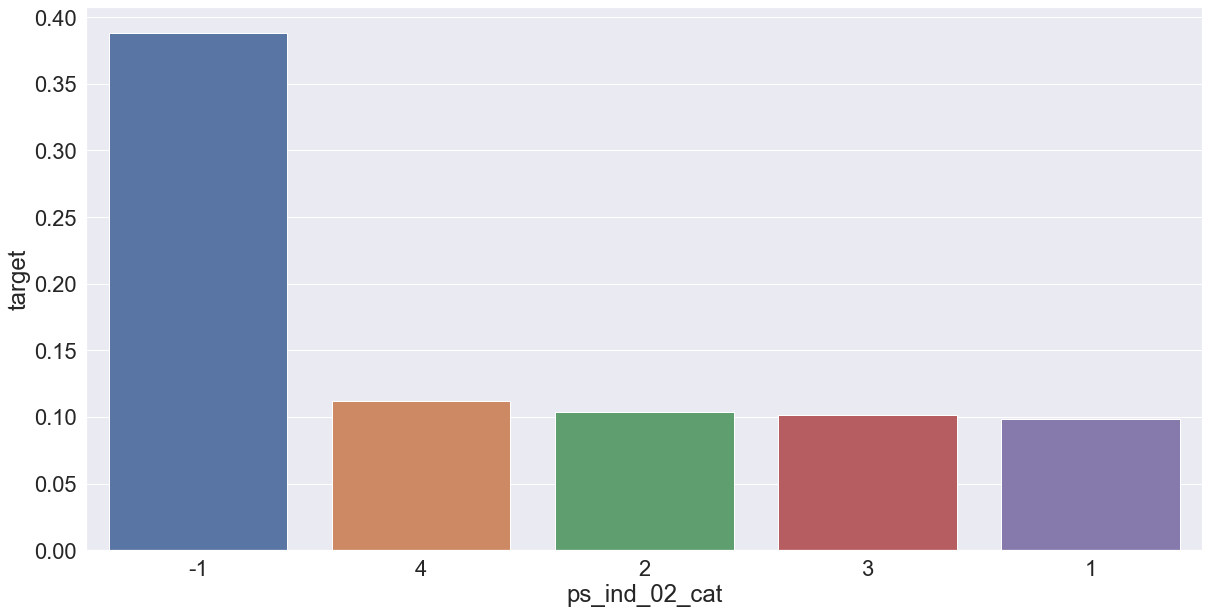

In [347]:
plt.figure()

fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x=column, y='target', data=cat_perc, order=cat_perc[column])
# x축을 column으로, y축을 target, 그리고 순서는 cat_perc[column] 순서로

<Figure size 432x288 with 0 Axes>

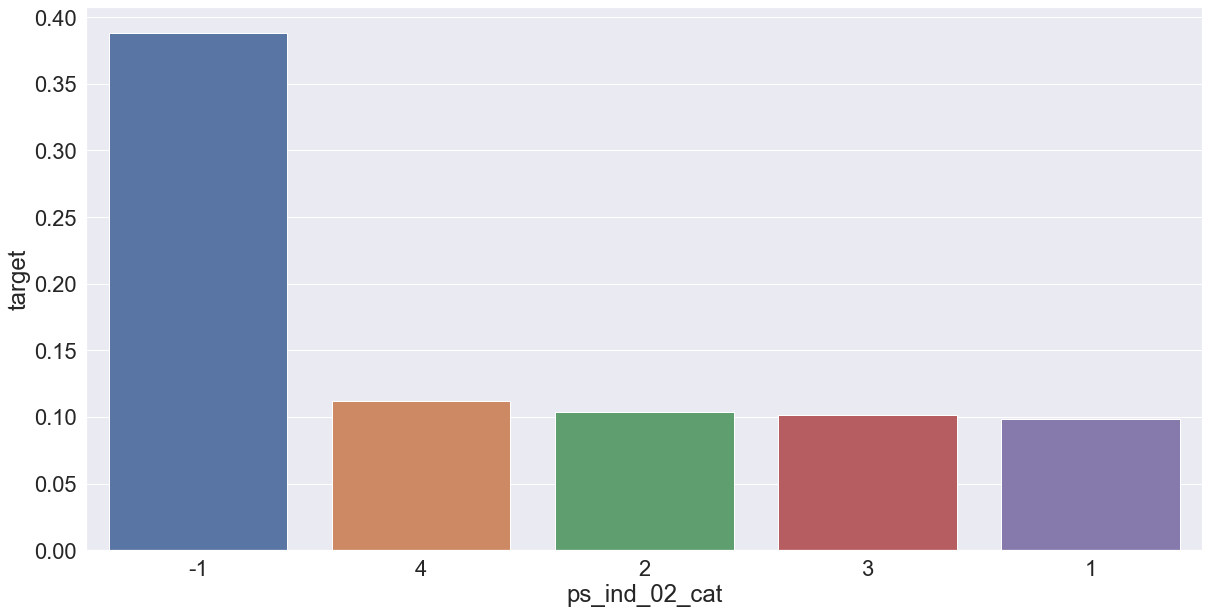

<Figure size 432x288 with 0 Axes>

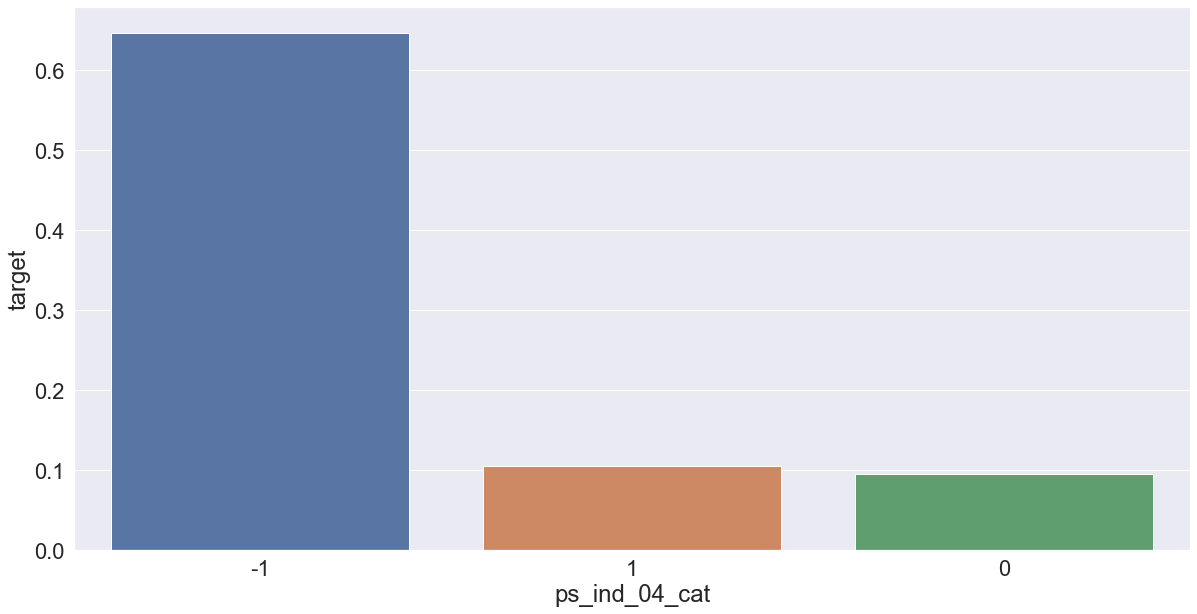

<Figure size 432x288 with 0 Axes>

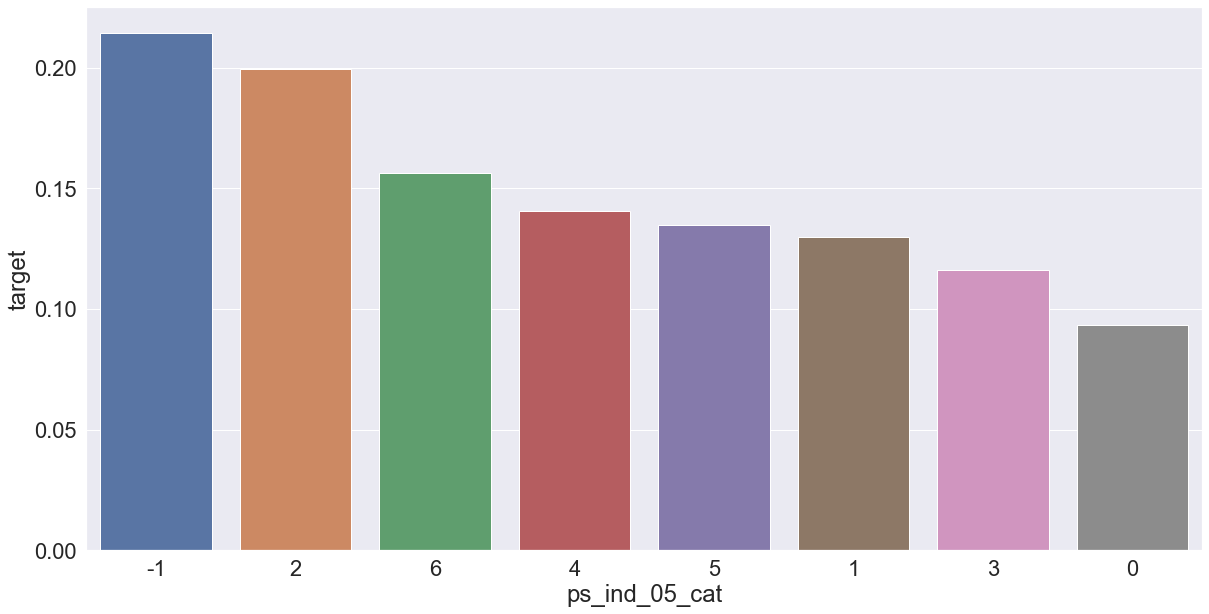

<Figure size 432x288 with 0 Axes>

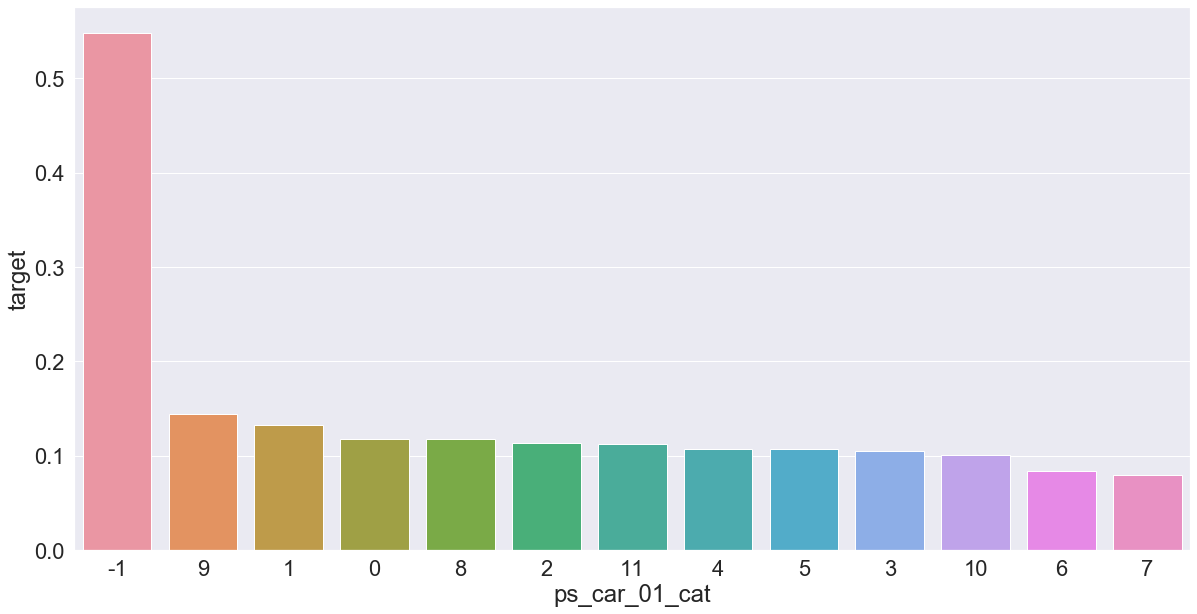

<Figure size 432x288 with 0 Axes>

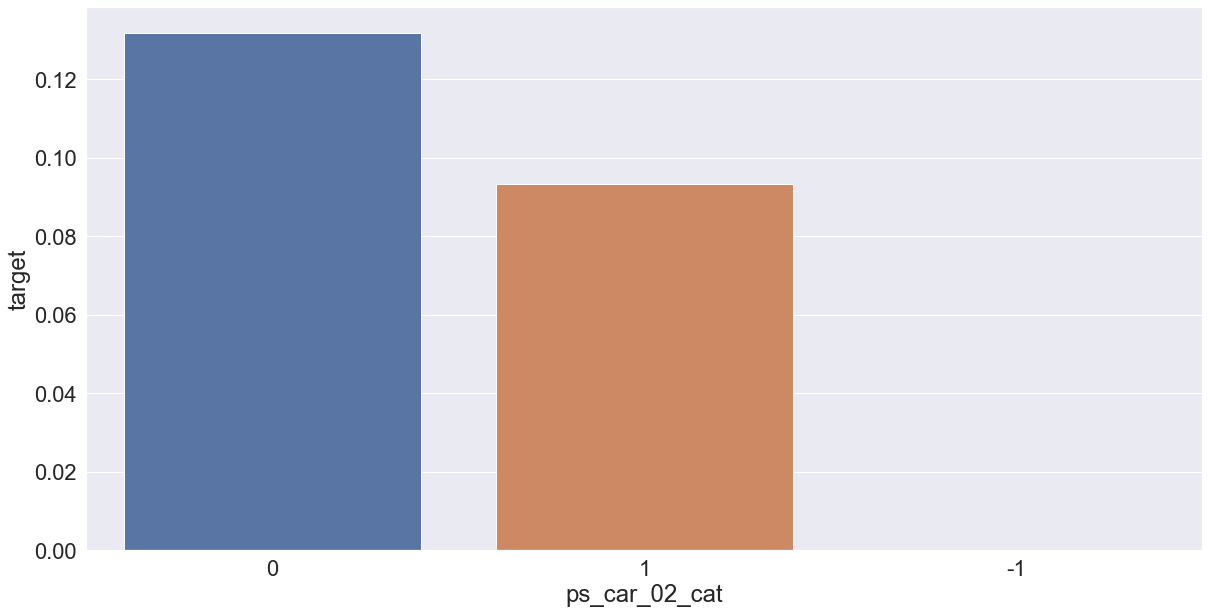

<Figure size 432x288 with 0 Axes>

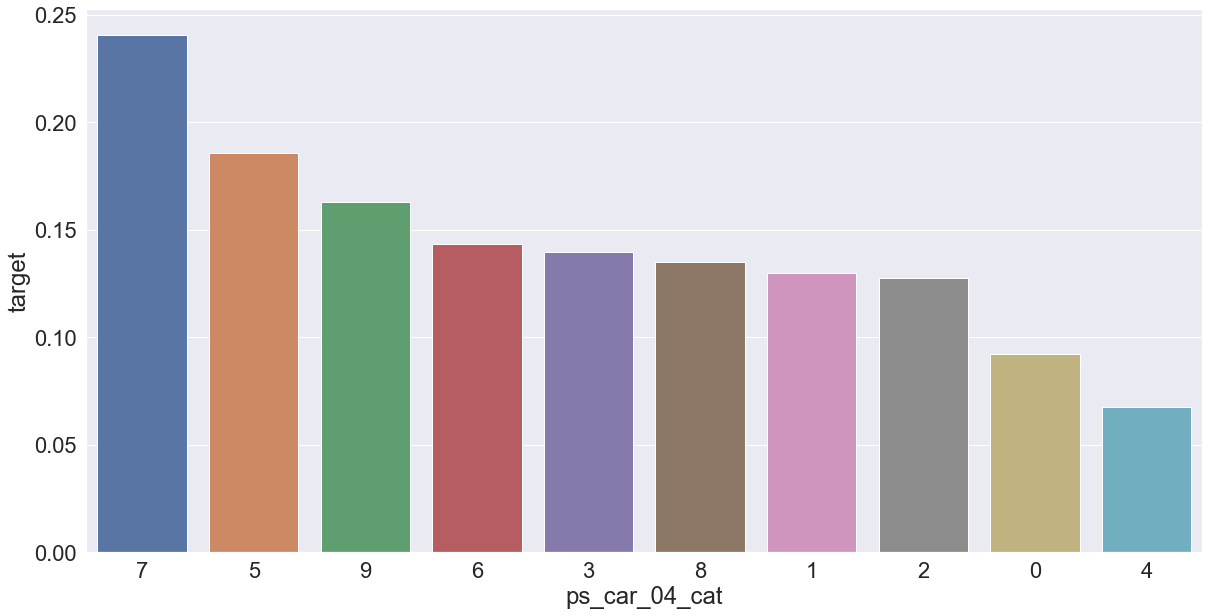

<Figure size 432x288 with 0 Axes>

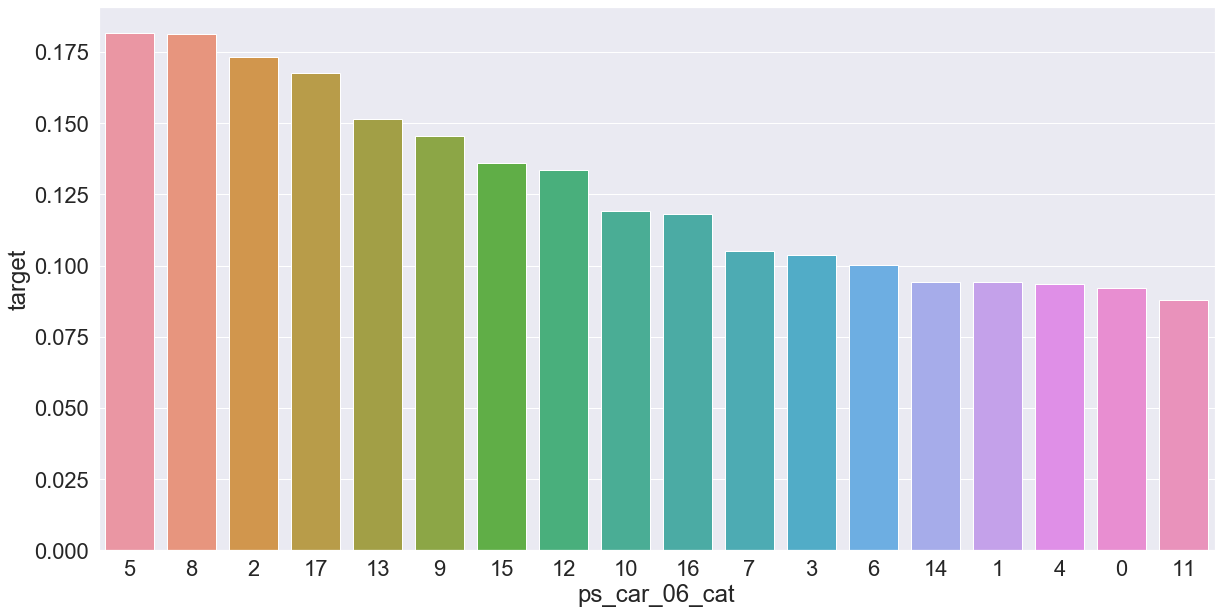

<Figure size 432x288 with 0 Axes>

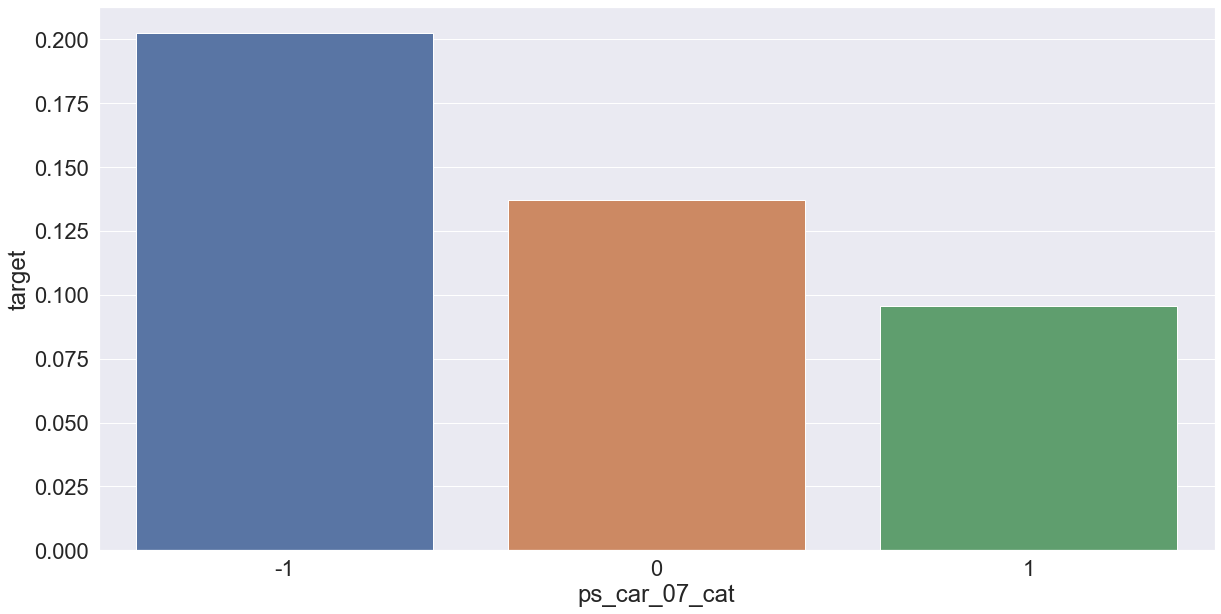

<Figure size 432x288 with 0 Axes>

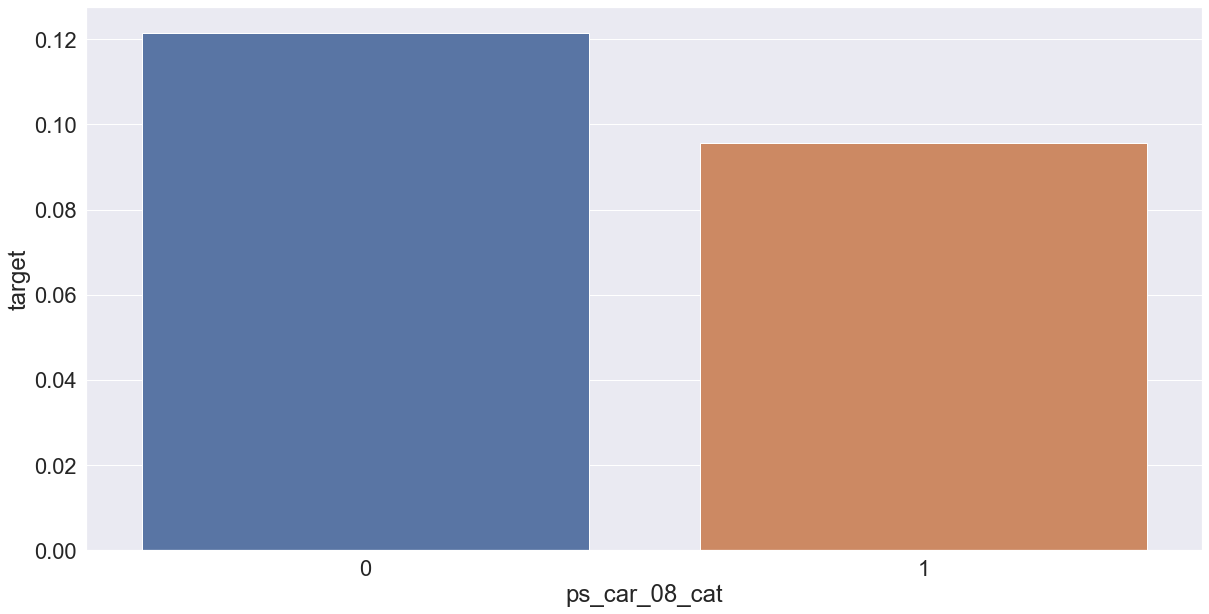

<Figure size 432x288 with 0 Axes>

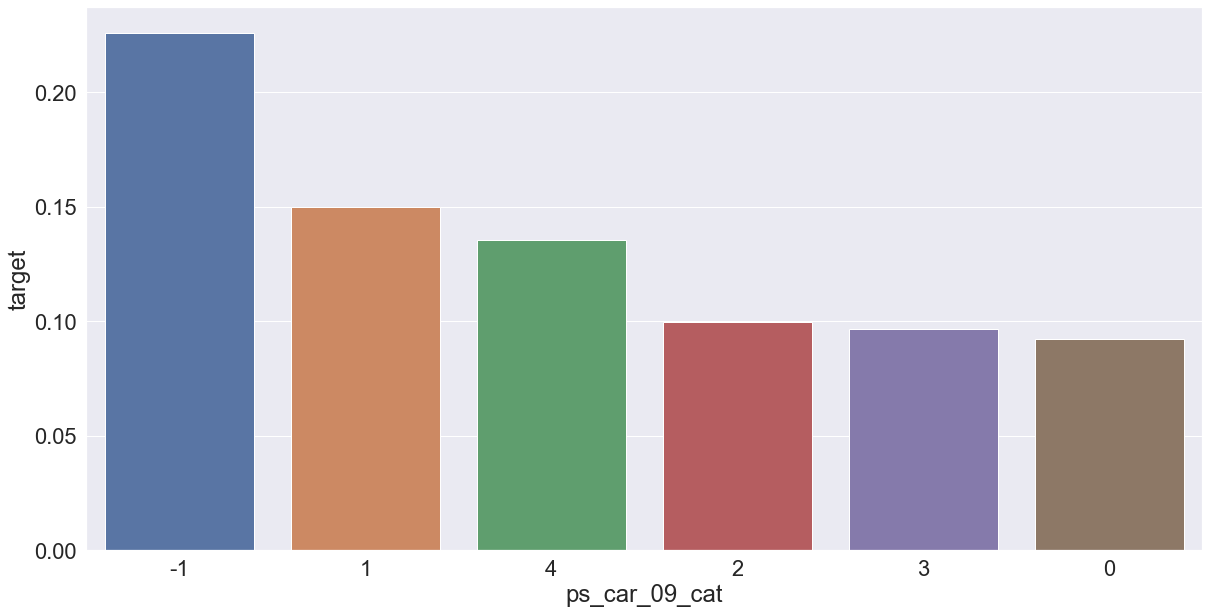

<Figure size 432x288 with 0 Axes>

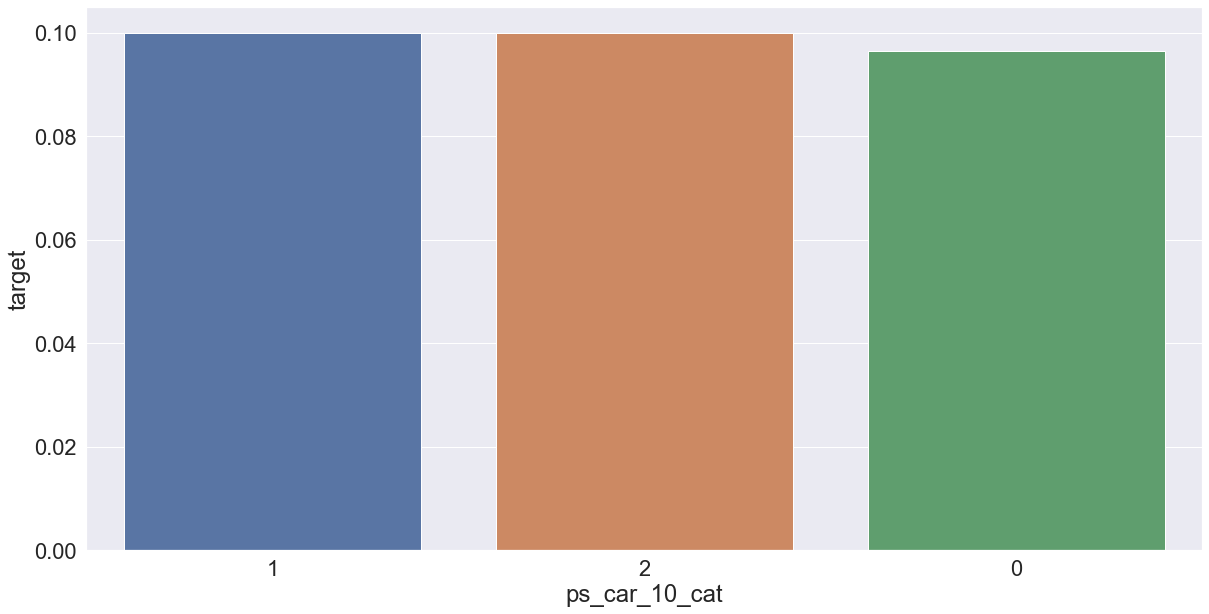

In [348]:
# 위를 종합

v = meta[(meta.level == 'nominal') & (meta.keep)].index

for column in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20, 10))
    
    cat_perc = train[[column, 'target']].groupby([column], as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    
    for i, p in enumerate(ax.patches):
        ax.annotate('{}'.format(cat_perc['target']['count'].values[i]),
                (p.get_height(), p.get_x()+0.5), fontsize=20)
    
    
    sns.barplot(x=column, y='target', data=cat_perc, order=cat_perc[column])
    sns.set(font_scale=2)
    
    plt.show()

- ps_ind_02_cat, ps_ind_04_cat 같은 경우 -1 (missing value)를 가지는 경우에 target값이 다른 값에 비해 큰 것을 볼 수 있다. 이는 좋은 변수가 될 수 있다.

- ps_car_02_cat 같은 경우는 -1의 target 값이 0 이다.

- 물론 이 값이 매우 적은 데이터 row로 이루어진 것일수 있으므로 count를 해보아야한다.

In [349]:
column = 'ps_car_02_cat'

cat_perc = train[[column, 'target']].groupby([column], as_index=False).agg(['mean','count'])
cat_perc

target        
                   mean   count
ps_car_02_cat                  
-1             0.000000       2
 0             0.131868   38000
 1             0.093233  178938

- 위와 같이 ps_car_02_cat 변수의 미싱밸류가 유의미한 것 처럼 보이나 샘플이 2개밖에 없는 경우가 있다.

- Missing value가 어느정도 의미를 지니는 것 같으니 채우지 않고 그냥 두자.

- 함부로 채우는 경우 변수에 Bias를 주게 될 수 있다.

- 그래프 자체에 Count까지 넣어주자 (YouHan Lee: My EDA 커널 참고): https://www.kaggle.com/youhanlee/my-eda-i-want-to-see-all

In [350]:
sum   # 원핫 인코딩을 하면 12개의 변수가 178개의 변수로 바뀐다.

178

- 원핫인코딩으로 변수의 개수가 너무 많아지면 우선 연산이 늘어나고, 또 Tree 모델에서 깊이도 깊어지고 중요한 피처를 빨리 찾지 못하는 등의 문제점이 생길 수 있다.

- 따라서, mean 인코딩이나 Frequency 인코딩도 사용한다.

- ps_car_11_cat 외에 나머지는 원핫인코딩도 괜찮다.

### Interval variables

- intervel 변수간의 상관관계를 확인하자. 히트맵을 활용하면 변수간의 상관관계를 유용하게 볼 수 있다.

In [351]:
# level이 interval인 변수 뽑아오기

v = meta[(meta.level == 'interval') & (meta.keep)].index

In [352]:
# interval 변수들끼리의 상관관계를 측정하는 함수

correlations = train[v].corr()

In [353]:
correlations

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
ps_reg_01,1.000000,0.470953,0.137117,0.019095,0.025243,-0.002536,0.001755,-0.003236,0.001459,-0.001371
ps_reg_02,0.470953,1.000000,0.702512,0.173736,0.193896,0.053149,0.052344,-0.001769,-0.000726,-0.000992
ps_reg_03,0.137117,0.702512,1.000000,0.208978,0.241244,0.079541,0.079848,-0.000223,0.000043,-0.000357
ps_car_12,0.019095,0.173736,0.208978,1.000000,0.674298,0.577537,0.049468,-0.000452,-0.001070,-0.000707
ps_car_13,0.025243,0.193896,0.241244,0.674298,1.000000,0.434613,0.526024,0.000266,0.000020,0.000568
ps_car_14,-0.002536,0.053149,0.079541,0.577537,0.434613,1.000000,0.008472,-0.004548,-0.005015,0.000776
ps_car_15,0.001755,0.052344,0.079848,0.049468,0.526024,0.008472,1.000000,-0.000392,0.003630,0.000586
ps_calc_01,-0.003236,-0.001769,-0.000223,-0.000452,0.000266,-0.004548,-0.000392,1.000000,0.002832,-0.000212
ps_calc_02,0.001459,-0.000726,0.000043,-0.001070,0.000020,-0.005015,0.003630,0.002832,1.000000,0.003130
ps_calc_03,-0.001371,-0.000992,-0.000357,-0.000707,0.000568,0.000776,0.000586,-0.000212,0.003130,1.000000


In [354]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

In [355]:
sns.set(font_scale=1.8)

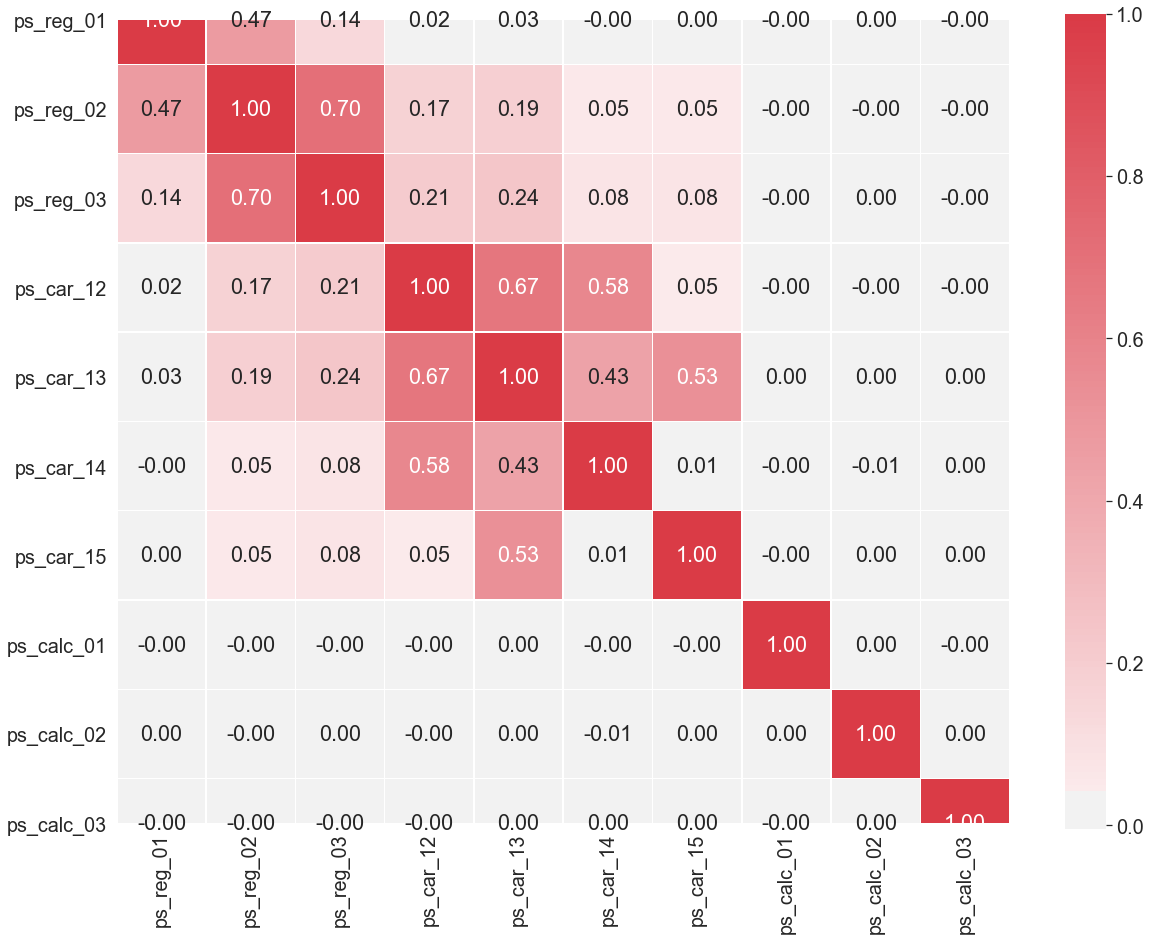

In [356]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f', square=True,
           linewidths=0.5, annot=True, cbar_kws={'shrink':0.75}, ax=ax)

plt.show()

- cmap: colormap(예쁘게 꾸미기)
- vmax: color가 값이 클수록 진하게 색상이 나타나는데 이때 0-1의 범위로 할건지 0~n의 범위로 할건지 정하는 파라미터 
- center: 색깔이 변함
- fmt: 소수점 몇자리까지
- square: 정사각형 모양으로
- linewidths: 각 셀마다 간격
- annot: 각 셀에 값을 입력할 것인지
- cbar_kws: color bar의 인자 (그림 오른쪽 범위 bar)

In [357]:
# corr_heatmap 종합 코드

def corr_heatmap(v):
    correlations = train[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(20,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();

#### 상관관계가 높은 변수들은 다음과 같다.

- ps_reg_02 and ps_reg_03 (0.7)
- ps_car_12 and ps_car_13 (0.67)
- ps_car_12 and ps_car_14 (0.58)
- ps_car_13 and ps_car_15 (0.53)

### Interval 변수의 Linear Model Fitting (상관관계가 높은 변수들끼리) 시각화

- 중요: **상관관계가 높은 것들의 데이터 포인트가 정말로 선형인것인지, 아니면 선형적인 특징이 없는데 숫자만 높게 나오게 된 것인지 확인을 하기위해 Visualization을 해야한다.**

- Fitting을 시키는 것은 컴퓨팅적으로 시간이 오래 걸릴수 있으므로 샘플을 가져온다

In [358]:
s = train.sample(frac=0.1)

##### ps_reg_02 and ps_reg_03

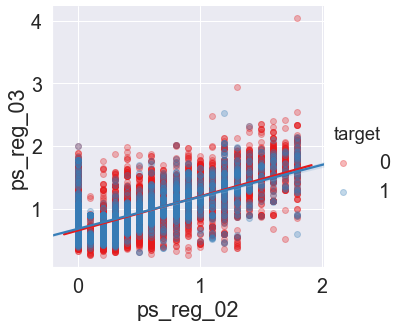

In [359]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1',
          scatter_kws={'alpha': 0.3})

plt.show()

- x, y: x축, y축
- data: 사용하려는 x, y축을 data 에서 가져오겠다
- hue: 점의 색깔을 target(0,1) 기준으로 넣어주겠다
- palette: 색
- scatter_kws, alpha: 산점도(scatter)의 투명도를 0.3으로 하겠다.

##### ps_car_12 and ps_car_13

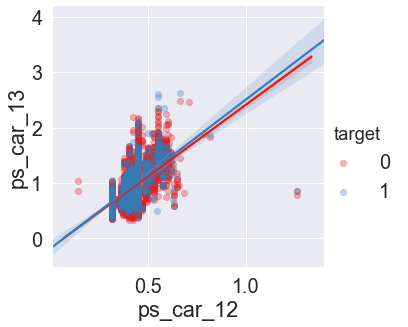

In [360]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1',
          scatter_kws={'alpha': 0.3})

plt.show()

##### ps_car_12 and ps_car_14


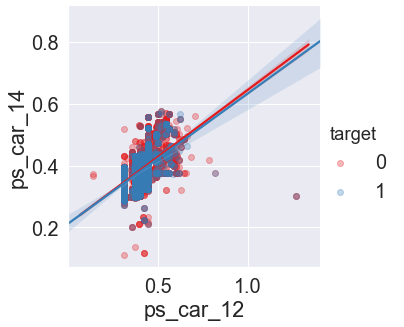

In [361]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

##### ps_car_13 and ps_car_15

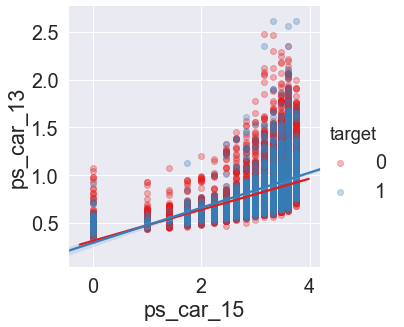

In [362]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

- High Correlation을 가지면 다중공선성을 가지게 된다.

- 둘 중 하나의 변수를 제거하는 방법이 있으나, PCA라는 방법이 유용

- 따라서 Principal Component Analysis(PCA)를 통해 변수의 차원을 줄이자

- PCA 참조 커널 : https://www.kaggle.com/bertcarremans/reducing-number-of-numerical-features-with-pca

- PCA를 쓰기전에 Standard Scaler를 통해 스케일을 변환해야함

### Ordinal variables
- Ordinal 변수간의 상관관계를 확인하자. Heatmap

In [363]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index

In [364]:
sns.set(font_scale=1.0)

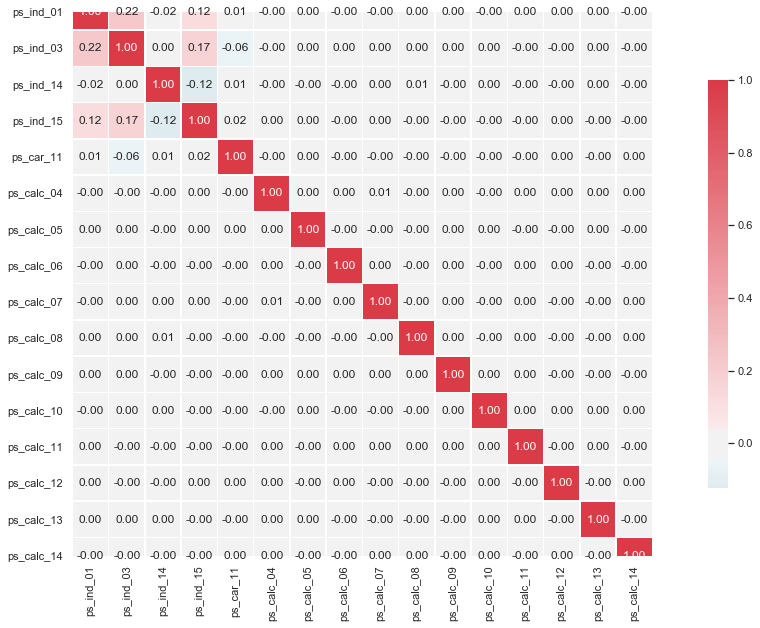

In [365]:
corr_heatmap(v)

- 위의 결과를 보면 Ordinal 변수는 상관관계가 높지 않다.

- 따라서 Target값으로 그룹화해서 분포를 보자.

## Feature Engineering

- 보통 카테고리 수가 적으면 One hot Encoding, 카테고리 수가 많으면 Mean, Frequency Encoding을 해주면 된다.

- 물론, 카테고리 수가 적어도 Target에 대해 Mean, Frequency가 의미가 보이면 One hot보다 좋다.

- 점수를 끌어올리려면 원핫 vs Mean & Frequency, 둘 중 선택하는 것이 아니라 두 방법 모두를 적용해 변수를 만들어서 사용 (Model Ensemble 등)

### Creating Dummy variables

- 카테고리컬 변수는 순서나 크고 작음이 있지 않다. 예를들어 category 2가 1의 두 배라는 개념이 아니다.  
- 그러므로 더미 변수를 만들어야한다.

In [366]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

In [367]:
print('Before dummification we have {} variables in train'.format(len(train.columns)))

train = pd.get_dummies(train, columns = v, drop_first=True)
# get_dummies함수 사용

print('After dummification we have {} variables in train'.format(len(train.columns)))

Before dummification we have 57 variables in train
After dummification we have 109 variables in train


- drop_first
    - 더미화로 만들어진 변수 중 첫 번째 변수제거
    - 나머지 변수가 모두 0이면 첫 번째 카테고리가 1인 것이 되기 때문에

- 52개의 더미변수가 생성되었음

### Creating interaction variables

- Feature를 곱하고 나누는 등의 작업을 통해 새로운 변수 생성

In [368]:
v = meta[(meta.level == 'interval') & (meta.keep)].index

In [369]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

- sklearn.preprocessing.PolynomialFeatures (변수들간에 곱셈을 해주는 함수)
    - degree=2 : 변수들끼리 모든 조합에 대해서 2차까지 곱하는것 (1, a, b, c) --> (1 * a, a * b, a * c, b * c 등)
    - interaction_only : 자기 자신을 제곱하는 것도 포함할지 말지 (a^2, b^2, c^2), True = 포함X
    - include_bias : bias column을 추가할지 말지

In [370]:
# 적용시키는 함수
poly.fit_transform(train[v])

# 생성된 Feature 이름 가져오는 함수
poly.get_feature_names(v)

['ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15',
 'ps_calc_01',
 'ps_calc_02',
 'ps_calc_03',
 'ps_reg_01 ps_reg_02',
 'ps_reg_01 ps_reg_03',
 'ps_reg_01 ps_car_12',
 'ps_reg_01 ps_car_13',
 'ps_reg_01 ps_car_14',
 'ps_reg_01 ps_car_15',
 'ps_reg_01 ps_calc_01',
 'ps_reg_01 ps_calc_02',
 'ps_reg_01 ps_calc_03',
 'ps_reg_02 ps_reg_03',
 'ps_reg_02 ps_car_12',
 'ps_reg_02 ps_car_13',
 'ps_reg_02 ps_car_14',
 'ps_reg_02 ps_car_15',
 'ps_reg_02 ps_calc_01',
 'ps_reg_02 ps_calc_02',
 'ps_reg_02 ps_calc_03',
 'ps_reg_03 ps_car_12',
 'ps_reg_03 ps_car_13',
 'ps_reg_03 ps_car_14',
 'ps_reg_03 ps_car_15',
 'ps_reg_03 ps_calc_01',
 'ps_reg_03 ps_calc_02',
 'ps_reg_03 ps_calc_03',
 'ps_car_12 ps_car_13',
 'ps_car_12 ps_car_14',
 'ps_car_12 ps_car_15',
 'ps_car_12 ps_calc_01',
 'ps_car_12 ps_calc_02',
 'ps_car_12 ps_calc_03',
 'ps_car_13 ps_car_14',
 'ps_car_13 ps_car_15',
 'ps_car_13 ps_calc_01',
 'ps_car_13 ps_calc_02',
 'ps_car_13 ps_calc_03',
 '

In [371]:
# 새로운 변수가 생성된 dataframe interactions에 저장
interactions = pd.DataFrame(data= poly.fit_transform(train[v]), columns=poly.get_feature_names(v))

interactions.drop(v, axis=1, inplace=True)  # 생성에 사용된 변수들 제거

In [372]:
interactions

,ps_reg_01 ps_reg_02,ps_reg_01 ps_reg_03,ps_reg_01 ps_car_12,ps_reg_01 ps_car_13,ps_reg_01 ps_car_14,ps_reg_01 ps_car_15,ps_reg_01 ps_calc_01,ps_reg_01 ps_calc_02,ps_reg_01 ps_calc_03,ps_reg_02 ps_reg_03,ps_reg_02 ps_car_12,ps_reg_02 ps_car_13,ps_reg_02 ps_car_14,ps_reg_02 ps_car_15,ps_reg_02 ps_calc_01,ps_reg_02 ps_calc_02,ps_reg_02 ps_calc_03,ps_reg_03 ps_car_12,ps_reg_03 ps_car_13,ps_reg_03 ps_car_14,ps_reg_03 ps_car_15,ps_reg_03 ps_calc_01,ps_reg_03 ps_calc_02,ps_reg_03 ps_calc_03,ps_car_12 ps_car_13,ps_car_12 ps_car_14,ps_car_12 ps_car_15,ps_car_12 ps_calc_01,ps_car_12 ps_calc_02,ps_car_12 ps_calc_03,ps_car_13 ps_car_14,ps_car_13 ps_car_15,ps_car_13 ps_calc_01,ps_car_13 ps_calc_02,ps_car_13 ps_calc_03,ps_car_14 ps_car_15,ps_car_14 ps_calc_01,ps_car_14 ps_calc_02,ps_car_14 ps_calc_03,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02 ps_calc_03
0,0.36,0.502892,0.221269,0.324362,0.207413,1.200000,0.54,0.18,0.00,0.502892,0.221269,0.324362,0.207413,1.200000,0.54,0.18,0.00,0.309095,0.453108,0.289739,1.676305,0.754337,0.251446,0.000000,0.199365,0.127483,0.737564,0.331904,0.110635,0.000000,0.186880,1.081207,0.486543,0.162181,0.000000,0.691375,0.311119,0.103706,0.000000,1.800000,0.600000,0.000000,0.27,0.00,0.00
1,0.54,0.655596,0.381838,0.344658,0.340933,0.000000,0.18,0.00,0.54,0.437064,0.254558,0.229772,0.227288,0.000000,0.12,0.00,0.36,0.309051,0.278958,0.275943,0.000000,0.145688,0.000000,0.437064,0.162473,0.160717,0.000000,0.084853,0.000000,0.254558,0.145068,0.000000,0.076591,0.000000,0.229772,0.000000,0.075763,0.000000,0.227288,0.000000,0.000000,0.000000,0.00,0.12,0.00
2,0.54,0.782340,0.360000,0.732844,0.362131,2.984962,0.27,0.81,0.09,0.521560,0.240000,0.488563,0.241421,1.989975,0.18,0.54,0.06,0.347707,0.707819,0.349765,2.883032,0.260780,0.782340,0.086927,0.325708,0.160947,1.326650,0.120000,0.360000,0.040000,0.327637,2.700631,0.244281,0.732844,0.081427,1.334504,0.120710,0.362131,0.040237,0.994987,2.984962,0.331662,0.27,0.03,0.09
3,0.90,1.023523,0.240000,0.503032,0.227051,2.163331,0.48,0.24,0.06,2.558808,0.600000,1.257580,0.567627,5.408327,1.20,0.60,0.15,0.682349,1.430181,0.645532,6.150610,1.364698,0.682349,0.170587,0.335355,0.151367,1.442221,0.320000,0.160000,0.040000,0.317260,3.022847,0.670710,0.335355,0.083839,1.364405,0.302734,0.151367,0.037842,2.884441,1.442221,0.360555,0.32,0.08,0.04
4,0.64,0.869253,0.320000,0.724622,0.307870,2.884441,0.48,0.40,0.72,0.869253,0.320000,0.724622,0.307870,2.884441,0.48,0.40,0.72,0.434626,0.984186,0.418151,3.917668,0.651939,0.543283,0.977909,0.362311,0.153935,1.442221,0.240000,0.200000,0.360000,0.348577,3.265825,0.543466,0.452888,0.815199,1.387552,0.230903,0.192419,0.346354,2.163331,1.802776,3.244996,0.30,0.54,0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216935,0.24,0.922591,0.254558,0.761467,0.230825,1.897367,0.30,0.06,0.30,0.615061,0.169706,0.507645,0.153883,1.264911,0.20,0.04,0.20,0.652371,1.951452,0.591547,4.862484,0.768826,0.153765,0.768826,0.538438,0.163218,1.341641,0.212132,0.042426,0.212132,0.488237,4.013282,0.634556,0.126911,0.634556,1.216553,0.192354,0.038471,0.192354,1.581139,0.316228,1.581139,0.05,0.25,0.05
216936,0.12,0.269658,0.127279,0.227094,0.120000,0.600000,0.09,0.12,0.18,0.359544,0.169706,0.302791,0.160000,0.800000,0.12,0.16,0.24,0.381354,0.680419,0.359544,1.797722,0.269658,0.359544,0.539317,0.321159,0.169706,0.848528,0.127279,0.169706,0.254558,0.302791,1.513957,0.227094,0.302791,0.454187,0.800000,0.120000,0.160000,0.240000,0.600000,0.800000,1.200000,0.12,0.18,0.24
216937,0.27,0.640756,0.360000,0.873589,0.335182,3.117691,0.45,0.36,0.54,0.213585,0.120000,0.291196,0.111727,1.039230,0.15,0.12,0.18,0.284781,0.691059,0.265148,2.466272,0.355976,0.284781,0.427171,0.388262,0.148970,1.385641,0.200000,0.160000,0.240000,0.361495,3.362445,0.485327,0.388262,0.582392,1.290116,0.1862

In [373]:
print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, interactions], axis=1)    
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

Before creating interactions we have 109 variables in train
After creating interactions we have 154 variables in train


- 기존 train에 interval 변수를 Feature Engineering 해서 만든 interactions를 Concat, axis=1

## Feature Selection

- 분산이 0이거나 작은 Features 제거 (의미가 없기 때문에)

- 보통은 알고리즘 모델에게 Feature를 알아서 학습하도록 한다.
- 그러나, 분산이 없거나 매우 낮은 경우에는 직접 제거를 하는 것이 낫다.

- sklearn의 VarianceThreshhold를 이용하면 쉽게 처리할 수 있다.

- 여기선 분산이 1% 이하이면 제거

In [374]:
selector = VarianceThreshold(threshold=0.01)
selector.fit(train.drop(['id', 'target'], axis=1))   # id와 target은 버리면 제거하면 안되기때문에

VarianceThreshold(threshold=0.01)

In [385]:
selector.get_support() == False

array([False, False, False, False, False, False,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True, False, False, False,
        True, False, False,  True, False, False,  True, False, False,
       False,  True, False, False, False,  True,  True, False, False,
       False, False, False, False, False,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

- selector.get_support() : 분산이 0.01(threshhold)를 넘은 변수는 True, 넘지못한 변수는 False
- 위의 결과를 넘지못한 변수를 True로 만들어 주기위해 == False

In [386]:
# id, target 제외한 컬럼들 중 분산이 0.01을 넘지 못한 변수들 v에 담기

v= train.drop(['id', 'target'], axis=1).columns[selector.get_support() == False]

In [389]:
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

26 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12 ps_car_14']


- 26개의 변수가 0.01을 넘지 못한다.
- 이는 120여개의 변수 중 많은 부분을 차지하므로 지우지 말자. (변수가 매우 많은 경우 제거하자)

- 대신 모델에게 선택하도록 하자.

- 꿀팁

- **Feature가 매우 많은 경우, 예를들어 1000개가 있다고 했을 때 Feature를 1개씩 넣고 빼고해서 성능을 보고 Selection하는 방법은 너무 오래걸린다.**
  
- **이럴때는, 10개 or 20개씩 묶음을 지어서 넣고 빼면서 성능을 재고 Selection하자.**

    - 랜덤하게 Feature 20개 사용한 모델 Baseline
    - Feature 40개 모델 학습 --> Baseline과 비교
    - if 성능 향상 --> Feature importance 상위 10% + 새로 추가된 Feature 생기면 남기고 안생기면 Randomly Choose
    - 반복

### Selecting Features with a Random Forest and SelectFromModel

여기서부턴 학습을 하면서 Feature를 뽑아낸다.

In [437]:
x_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feature_labels = x_train.columns     # Feature

rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=3)   # 랜덤포레스트 분류기

rf.fit(x_train, y_train)    # 학습적용,  rf.fit(x데이터, y데이터)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=3,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [438]:
# Feature importance (피처의 중요도)
importances = rf.feature_importances_

In [439]:
# 중요도가 0~큰순으로 되어있는데 이것을 큰것~0순으로 정렬 (그리고 그때의 index를 가져오는 함수)
indices = np.argsort(rf.feature_importances_)[::-1]

In [440]:
# 각 Feature마다 Feature importance를 보여주는 코드
for f in range(x_train.shape[1]):
    print(('{}) {} {:.6f}'.format(f+1, feature_labels[indices[f]], importances[indices[f]])))

1) ps_car_11_cat_te 0.022806
2) ps_car_13 0.019243
3) ps_car_12 ps_car_13 0.019060
4) ps_reg_03 ps_car_13 0.018973
5) ps_car_13 ps_car_14 0.018823
6) ps_reg_01 ps_car_13 0.018357
7) ps_car_13 ps_car_15 0.018281
8) ps_reg_03 ps_car_14 0.017936
9) ps_reg_03 ps_car_12 0.017038
10) ps_car_14 ps_car_15 0.016802
11) ps_reg_03 ps_car_15 0.016575
12) ps_car_13 ps_calc_01 0.016117
13) ps_reg_01 ps_reg_03 0.016104
14) ps_car_13 ps_calc_03 0.015996
15) ps_reg_02 ps_car_13 0.015946
16) ps_reg_01 ps_car_14 0.015868
17) ps_car_13 ps_calc_02 0.015830
18) ps_reg_03 0.015775
19) ps_reg_03 ps_calc_02 0.014945
20) ps_reg_03 ps_calc_03 0.014927
21) ps_car_14 ps_calc_02 0.014918
22) ps_car_14 ps_calc_03 0.014848
23) ps_car_14 0.014781
24) ps_reg_03 ps_calc_01 0.014757
25) ps_car_12 ps_car_14 0.014733
26) ps_car_14 ps_calc_01 0.014615
27) ps_calc_10 0.014586
28) ps_calc_14 0.014119
29) ps_reg_02 ps_car_14 0.013930
30) ps_reg_02 ps_reg_03 0.013724
31) ps_ind_03 0.013703
32) ps_calc_11 0.013490
33) ps_ind_15 

- SelectFromModel을 이용하면 

In [447]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)

print('Number of features before selection: {}'.format(x_train.shape[1]))
n_features = sfm.transform(x_train).shape[1]
print('Number of features after selection: {}'.format(n_features))

Number of features before selection: 152
Number of features after selection: 76


- threshold = 'median' : Feature importance가 median 기준 이상인 것만 사용하겠다.
- prefit: 위에서 학습한 모델을 주겠다(True) or 새로 학습을 하겠다.(False)

In [454]:
selected_vars = list(feature_labels[sfm.get_support()])

- sfm.get_support(): SelectFromModel의 threshhold를 기준으로 True,False 반환
- 그 후 True인 변수들만 가져와서 list로 담아주기

In [457]:
train = train[selected_vars + ['target']]     # 선택된 변수와 target

In [458]:
train.shape    # 77개로 줄어있는것을 볼 수 있다.

(216940, 77)

## Feature Scaling

- training data에 Standard Scaling 적용

- Feature의 Scale에 영향을 미치는 Classifier들 같은 경우는 거의 무조건 해주는 것이 좋다.

- 다만, Random Forest와 같이 Tree 계열은 굳이 해줄 필요는 없다.

In [465]:
scaler = StandardScaler()

scaler.fit_transform(train.drop(['target'], axis=1))

array([[-0.45941104, -1.26665356,  1.05087653, ...,  0.33629291,
        -1.00982477, -1.01071913],
       [ 1.55538958,  0.95034274, -0.63847299, ..., -1.01051216,
        -0.41144469, -1.01071913],
       [ 1.05168943, -0.52765479, -0.92003125, ...,  0.33629291,
        -0.86022975, -0.56215309],
       ...,
       [-0.9631112 ,  0.58084336,  0.48776003, ..., -0.01287878,
         0.48612543,  0.18545696],
       [-0.9631112 , -0.89715418, -1.48314775, ..., -0.51169547,
         0.48612543, -0.41263108],
       [-0.45941104, -1.26665356,  1.61399304, ..., -0.41193213,
        -0.71063473, -0.11358706]])

In [472]:
scaler.mean_    # Fit시킨 변수의 평균들이 저장되어 있음. var에는 분산저장 등등

array([1.91207246, 4.42802618, 7.26764082, 0.12515903, 0.61298977,
       0.44501659, 0.89886103, 2.34490643, 0.38074061, 0.81718574,
       0.37469526, 3.07107577, 0.44982806, 0.44983544, 0.45023693,
       2.37152208, 1.8835254 , 7.69035217, 2.99878307, 9.22325528,
       2.33656311, 8.43145109, 5.44289665, 1.43957315, 2.87266064,
       7.54363418, 0.55519959, 0.28697797, 0.34918411, 0.0999991 ,
       0.88394948, 0.32806108, 0.5634149 , 0.23371181, 0.50257231,
       0.22965213, 1.88290604, 0.2754729 , 0.27586466, 0.27587757,
       0.49051939, 0.17359874, 0.38163975, 0.16770627, 1.38229171,
       0.19997331, 0.2000992 , 0.20024666, 0.34609831, 0.7518042 ,
       0.33790881, 2.77885471, 0.40431272, 0.40434341, 0.40466808,
       0.32011185, 0.14416035, 1.17140143, 0.17126019, 0.17125263,
       0.17141159, 0.31055984, 2.59680109, 0.36761045, 0.36760042,
       0.3679642 , 1.15099119, 0.16849064, 0.1684876 , 0.1687115 ,
       1.38137377, 1.38223836, 1.38283452, 0.20258187, 0.20251

- 꿀팁, fit, transform을 적용시킬 때는 항상 test에는 fit을 시키는 것이 아니라 transform만 적용
    - Example)
    - scaler = StandardScaler()
    - df_train = scaler.fit_transform(df_train)
    - df_test = scaler.transform(df_test)